In [ ]:
!add-apt-repository -y ppa:ubuntu-toolchain-r/test
!apt-get update
!apt-get install gcc-9 g++-9
!apt-get install gfortran-9
!apt-get install libblas-dev liblapack-dev
!apt-get install libopenblas-dev
!apt-get install scons
!apt-get install libpng-dev
!apt-get install libboost-all-dev freeglut3-dev
!apt-get install xvfb
!apt-get install libspatialindex-dev

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backpor

In [ ]:
!pip install torch==1.0.1 rtree trimesh

     |████████████████████████████████| 560.1MB 30kB/s 
     |████████████████████████████████| 1.0MB 1.4MB/s 
     |████████████████████████████████| 634kB 1.0MB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.0.1 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101


In [ ]:
!update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-9 900
!update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-9 900

!update-alternatives --set gcc "/usr/bin/gcc-9"
!update-alternatives --set g++ "/usr/bin/g++-9"

update-alternatives: using /usr/bin/gcc-9 to provide /usr/bin/gcc (gcc) in auto mode
update-alternatives: using /usr/bin/g++-9 to provide /usr/bin/g++ (g++) in auto mode


In [ ]:
%cd /content

/content


In [ ]:
!git clone https://github.com/mszarski/DifferentiableCloth

Cloning into 'DifferentiableCloth'...
remote: Enumerating objects: 2225, done.
remote: Counting objects: 100% (2225/2225), done.
remote: Compressing objects: 100% (1992/1992), done.
remote: Total 2225 (delta 194), reused 2126 (delta 127), pack-reused 0
Receiving objects: 100% (2225/2225), 31.80 MiB | 22.25 MiB/s, done.
Resolving deltas: 100% (194/194), done.


In [ ]:
!chmod +x DifferentiableCloth/arcsim/dependencies/taucs/configure

In [ ]:
%cd /content

/content


In [ ]:
%cd DifferentiableCloth
%cd arcsim/dependencies/
!make -j8


/content/DifferentiableCloth
/content/DifferentiableCloth/arcsim/dependencies
cd alglib/cpp/src && g++ -c -fPIC *.cpp && ar rcs libalglib.a *.o
cd jsoncpp && scons platform=linux-gcc
cd taucs && ./configure module=\!METIS && make
./configure: 27: ./configure: [[: not found
make[1]: Entering directory '/content/DifferentiableCloth/arcsim/dependencies/taucs'
cc -o configurator/configurator configurator/taucs_config.c
configurator/taucs_config.c: In function ‘emit_configfile’:
configurator/taucs_config.c:244:5: warning: implicit declaration of function ‘mkdir’ [-Wimplicit-function-declaration]
  244 |     mkdir(configdir);
      |     ^~~~~
make[1]: Leaving directory '/content/DifferentiableCloth/arcsim/dependencies/taucs'

make[1]: Entering directory '/content/DifferentiableCloth/arcsim/dependencies/taucs'
mkdir obj
mkdir bin
mkdir lib
mkdir obj/linux/
mkdir bin/linux/
mkdir lib/linux/
echo exists > obj/linux/exists.log
echo exists > bin/linux/exists.log
cc -c -O3 -Wall -fPIC -std=c99   

In [ ]:
%cd ../..
!make -j8
%cd pysim
!ln -s ../arcsim/conf ./conf
!ln -s ../arcsim/materials ./materials
!ln -s ../arcsim/meshes ./meshes

%cd ..
%cd demo
!ln -s ../arcsim/conf ./conf
!ln -s ../arcsim/materials ./materials
!ln -s ../arcsim/meshes ./meshes

/content/DifferentiableCloth
CXX arcsim/src/util.cpp
CXX arcsim/src/taucs.cpp
g++ arcsim/src/util.cpp -MMD -MP -pthread -fPIC -fwrapv -std=c++17 -DNDEBUG -O3 -I/usr/include/python3.6m -INo -ICUDA -Iruntime -Iis -Ifound, -Iusing -ICUDA_HOME='/usr/local/cuda' -I/usr/local/lib/python3.6/dist-packages/torch/lib/include -I/usr/local/lib/python3.6/dist-packages/torch/lib/include/torch/csrc/api/include -I/usr/local/lib/python3.6/dist-packages/torch/lib/include/TH -I/usr/local/lib/python3.6/dist-packages/torch/lib/include/THC -Iarcsim/dependencies/include -Iarcsim/src -DTORCH_API_INCLUDE_EXTENSION_H -D_GLIBCXX_USE_CXX11_ABI=0 -Wall -Wno-sign-compare -Wcomment -c -o arcsim/objs/util.o
g++ arcsim/src/taucs.cpp -MMD -MP -pthread -fPIC -fwrapv -std=c++17 -DNDEBUG -O3 -I/usr/include/python3.6m -INo -ICUDA -Iruntime -Iis -Ifound, -Iusing -ICUDA_HOME='/usr/local/cuda' -I/usr/local/lib/python3.6/dist-packages/torch/lib/include -I/usr/local/lib/python3.6/dist-packages/torch/lib/include/torch/csrc/api/i

In [ ]:
##restart runtime here

In [1]:
%cd /content/DifferentiableCloth/pysim/

/content/DifferentiableCloth/pysim


In [ ]:
from google.colab import drive
from os.path import join

ROOT = '/content/drive'     # default for the drive
PROJ = 'My Drive/draping_workspace'       # path to your project on Drive

drive.mount(ROOT)

Mounted at /content/drive


In [2]:
%%writefile conf/double_hump_draping.json
{
    "frame_time": 0.08,
    "frame_steps": 2,
    "end_time": 10,
    "cloths": [
    {
        "mesh": "/content/drive/My Drive/draping_workspace/double_hump_mm_flatmesh_99pc.obj",
        "transform":{"scale":0.01,"translate":[-0.1,-0.3,0.5]},
        "materials": [{"data": "materials/gray-interlock.json",
                      "stretching_mult":1e-3,
                      "bending_mult":1e4,
                       "thicken": 2}],
        "remeshing": {
            "refine_angle": 0.3,
            "refine_compression": 0.005,
            "refine_velocity": 0.5,
            "size": [10e-3, 100e-3],
            "aspect_min": 0.2
        }
    }
    ],
    "obstacles": [
    {
        "mesh": "/content/drive/My Drive/draping_workspace/double_hump_mm.obj",
        "transform":{"scale":0.01,"translate":[-0.1,-0.3,-0.5]},
        "velocity": [0, 0, 0, 0, 0, 0],
        "movable": 0
    }
    ],
    "friction": 0.0,
    "obs_friction": 10000.0,
    "disable":["remeshing", "plasticity", "strainlimiting", "separation"],
    "gravity":[0, 0, -9.8],
    "magic": {"repulsion_thickness": 5e-3, "collision_stiffness": 1e6}
}

Overwriting conf/double_hump_draping.json


In [3]:
import trimesh
import trimesh.transformations as tf
import numpy as np

curved_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/double_hump_mm.obj',process=False)
flat_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/double_hump_mm_flatmesh_99pc.obj',process=False)
scene = trimesh.Scene(base_frame='world')
curved_mesh.apply_scale(0.01)
flat_mesh.apply_scale(0.01)

transform = tf.translation_matrix([-0.1,-0.3,0.5])
flat_mesh.apply_transform(transform)
f_id = scene.add_geometry(flat_mesh)

transform = tf.translation_matrix([-0.1,-0.3,-0.5])
curved_mesh.apply_transform(transform)
c_id = scene.add_geometry(curved_mesh)

handles = [39, 297, 239, 581]
steps = 20

trajectories = []

for handle in handles:
    ray_origin = flat_mesh.vertices[handle]
    
    ray_direction = curved_mesh.vertices[handle] - flat_mesh.vertices[handle]
    ray_direction = ray_direction

    locations, index_ray, index_tri = curved_mesh.ray.intersects_location(
        ray_origins=np.array([ray_origin]),
        ray_directions=np.array([ray_direction]))

    location = locations[0]
    path = np.dstack([np.linspace(ray_origin[0],location[0],steps),np.linspace(ray_origin[1],location[1],steps),np.linspace(ray_origin[2],location[2],steps)])

    path = path.squeeze()
    trajectories.append(path)

pos_trajectories = np.array(trajectories) #this is positions, not vs
v_trajectories = np.diff(pos_trajectories,axis=1) #vs
v_trajectories = v_trajectories.transpose(1,0,2)
v_trajectories = np.concatenate([v_trajectories,np.expand_dims(np.zeros_like(v_trajectories[0]),0)])

pos_trajectories = pos_trajectories.transpose(1,0,2)
pos_trajectories = np.concatenate([pos_trajectories,np.expand_dims(np.zeros_like(pos_trajectories[0]),0)])

scene.show()

In [4]:
#test slide
v_trajectories[22-5][:][:,0] += 100

In [ ]:
v_trajectories[22-5]

array([[ 7.54190897e-01,  2.08248458e-04, -5.26315789e-02],
       [ 7.54048939e-01, -9.20984774e-04, -5.62281895e-02],
       [ 7.45836473e-01, -1.15809109e-03, -5.26315789e-02],
       [ 7.47848277e-01,  4.27007253e-04, -4.84894584e-02]])

In [4]:
!rm -rf /content/double_hump_draping_default_out

In [5]:
import networkx as nx
import torch

torch_curved_v = torch.tensor(curved_mesh.vertices,dtype=torch.float64)

#precalculate all pairs shortest paths
G = nx.Graph()
G.add_edges_from(flat_mesh.edges_unique)
P = dict(nx.all_pairs_shortest_path(G))

def contact_front_loss_graph(sim, seed_pt_idx):
    dists = []
    for i in range(len(sim.cloths[0].mesh.nodes)):
        dists.append(sim.cloths[0].mesh.nodes[i].x - torch_curved_v[i])

    z_dists = torch.stack(dists)[:,2]

    pos_z_dists = torch.nn.functional.relu(z_dists)
    thresh = 5e-3
    weights = torch.exp(-pos_z_dists/thresh)

    vertex_connectivity = torch.tensor(0.0,dtype=torch.float64)

    for j in range(len(sim.cloths[0].mesh.nodes)):
        vertex_connectivity += weights[P[seed_pt_idx][j]].prod()

    loss = -vertex_connectivity

    return loss

In [ ]:
import torch
import arcsim
import gc
import time
import json
#import sysx
import gc
import os
#import numpy as np

from datetime import datetime
now = datetime.now()
timestamp = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')

out_path = '/content/double_hump_draping_default_out'

if not os.path.exists(out_path):
  os.mkdir(out_path)

with open('conf/double_hump_draping.json','r') as f:
  config = json.load(f)

def save_config(config, file):
  with open(file,'w') as f:
    json.dump(config, f)

save_config(config, out_path+'/conf.json')

torch.set_num_threads(8)
spf = config['frame_steps']
frame_time = config['frame_time']
scalev=1

##
steps = 20
trajectories = v_trajectories[:steps]
torch_pos_trajectories = torch.tensor(pos_trajectories[:steps],dtype=torch.float64)

pre_steps = 5
#epochs=10
epochs=5

boundary = [511, 509, 518, 523, 524,  30,  28,  26,  35,  36, 429, 428, 430,
        398, 395, 393,  43,  40,  39,  38,  42, 406, 404, 408, 411, 416,
        417, 385, 383, 388, 475, 474, 478, 481,  22,  20,  14,  13,  15,
        261, 260, 253, 250, 254, 263, 265, 269, 288, 292, 289, 293, 297,
        298, 310, 311, 312, 313, 368, 369, 372, 379, 380, 188, 186, 185,
        187, 189, 192, 226, 228, 231, 232, 233, 234, 236, 239, 238, 237,
        221, 216, 215, 213, 212, 153, 149, 147, 129, 125, 123, 115, 116,
        108, 111, 112, 606, 605, 604, 599, 598, 596, 595, 590, 586, 587,
        592, 593, 594, 580, 581, 577, 576, 513]

seed_pt_idx = 324

def reset_sim(sim, epoch):
  if epoch < epochs:
    arcsim.init_physics(out_path+'/conf.json', out_path+'/out%d'%epoch,False)
  else:
    arcsim.init_physics(out_path+'/conf.json',out_path+'/out',False)

  # total_m = 0.0

  # for i in range(len(sim.cloths[0].mesh.nodes)):
  #   total_m += sim.cloths[0].mesh.nodes[i].m

  # mu = sim.obs_friction
  # mu.requires_grad = True

  # return total_m, mu

def run_sim(steps,sim,param_v):

  boundary_losses = []
  seed_pt_losses = []
  contact_losses = []
  handle_losses = []

  total_steps = (pre_steps + steps) * spf

  print("step")
  for step in range(total_steps):
    print(step)

    v_idx = step // spf - pre_steps

    if step > (pre_steps*spf)-1:
      for i in range(len(handles)):
        sim.cloths[0].mesh.nodes[handles[i]].v += param_v[v_idx,i] /spf #* spf
        #print(sim.cloths[0].mesh.nodes[handles[i]].x)
        #handle_loss += torch.norm((sim.cloths[0].mesh.nodes[handles[i]].x - torch_pos_trajectories[v_idx]))

      #print(handle_loss)
      #handle_losses.append(handle_loss)
  
      # from IPython.core.debugger import set_trace
      # set_trace()

      if step%spf == 0:
        # step_contact_loss = contact_front_loss_graph(sim, seed_pt_idx)
        # contact_losses.append(step_contact_loss)

        # step_seed_pt_loss = torch.norm((sim.cloths[0].mesh.nodes[seed_pt_idx].x - torch_curved_v[seed_pt_idx]))
        # seed_pt_losses.append(step_seed_pt_loss)

        # # loss_idxs = [*boundary]
        # loss_idxs = [*handles]
        # step_boundary_loss = torch.tensor(0.0,dtype=torch.float64)
        # for i in loss_idxs:
        #   step_boundary_loss += torch.norm(torch_curved_v[i] - sim.cloths[0].mesh.nodes[i].x, p=1)

        # boundary_losses.append(step_boundary_loss)

        handle_loss = torch.tensor(0.0,dtype=torch.float64)

        for i in range(len(handles)):
          handle_loss += torch.norm((sim.cloths[0].mesh.nodes[handles[i]].x - torch_pos_trajectories[v_idx,i]))

        handle_losses.append(handle_loss)

        #print(f"contact loss: {step_contact_loss}, seed_pt_loss: {step_seed_pt_loss}, boundary loss: {step_boundary_loss}")

    arcsim.sim_step()

  # v_limit = 0.5 #was 0.25
  # stiffness = 2
  # weight = 2/30 * steps * 1/7 * len(loss_idxs)
  # v_constraint = torch.sum(weight / (1.0+torch.exp(stiffness*(1.0 - (torch.abs(param_v)/v_limit)))))

  # avg = torch.mean(param_v,dim=1,keepdim=True)
  # reg = (torch.norm(param_v-avg, dim=2)**2).mean()

  #total_loss = loss #+ reg #+ v_constraint

  # # e = [0,20*spf,40*spf]
  # e = [0,20,40]
  # sw = [1.0,0.0,0.0]
  # cw = [0.0,1.0,0.0]
  # bw = [0.0,0.0,1.0]
  # seed_pt_weight = torch.tensor(np.interp(list(range(steps*spf)),e,sw))
  # contact_weight = torch.tensor(np.interp(list(range(steps*spf)),e,cw))
  # boundary_weight = torch.tensor(np.interp(list(range(steps*spf)),e,bw))

  # seed_pt_weight = torch.tensor(np.interp(list(range(steps)),e,sw))
  # contact_weight = torch.tensor(np.interp(list(range(steps)),e,cw))
  # boundary_weight = torch.tensor(np.interp(list(range(steps)),e,bw))

  # contact_loss_steps = torch.stack(contact_losses,dim=0)
  # contact_loss = torch.sum(contact_loss_steps*contact_weight)

  # seed_pt_loss_steps = torch.stack(seed_pt_losses,dim=0)
  # seed_pt_loss = torch.sum(seed_pt_loss_steps*seed_pt_weight)

  # boundary_loss_steps = torch.stack(boundary_losses,dim=0)
  # boundary_loss = torch.sum(boundary_loss_steps*boundary_weight)

  # avg = torch.mean(contact_loss_steps)
  # var = torch.norm(contact_loss_steps-avg)**2
  # reg = var/steps

  #reg_lambda = 0
  # seed_pt_lambda = 1
  # contact_lambda = 1e-2
  # boundary_lambda = 1e-1
  # print(f"contact loss: {contact_loss*contact_lambda}, seed_pt_loss: {seed_pt_loss*seed_pt_lambda}, boundary loss: {boundary_loss*boundary_lambda}")

  # total_loss = contact_loss*contact_lambda + seed_pt_loss*seed_pt_lambda + boundary_loss*boundary_lambda

  # total_loss = seed_pt_loss*seed_pt_lambda

  handle_loss_steps = torch.stack(handle_losses,dim=0)
  handle_loss = torch.sum(handle_loss_steps)

  for tensor in handle_loss_steps:
      del tensor
  del handle_loss_steps

  del handle_losses

  total_loss = handle_loss

  return total_loss


with open(out_path+('/log%s.txt'%timestamp),'w',buffering=1) as f:
  tot_step = 1
  sim=arcsim.get_sim()
  #total_m, _ = reset_sim(sim,0)
  #print(total_m)

  total_m = 1.2

  #param_v = torch.zeros([steps, 4,3],dtype=torch.float64, requires_grad=True)
  m_trajectories = np.array(trajectories)
  m_trajectories[:,:,2] += 1.0*(total_m /4 * -(-9.8))

  param_v = torch.tensor(m_trajectories/(frame_time/spf),dtype=torch.float64, requires_grad=True)

  # optimizer = torch.optim.Adam([param_v],lr=0.01)
  # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=0, verbose=True)

  optimizer = torch.optim.Adam([param_v],lr=0.5)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, verbose=True)

  epoch = 0
  while True:
    reset_sim(sim, epoch)
    st = time.time()

    optimizer.zero_grad()

    loss = run_sim(steps, sim, param_v)
    en0 = time.time()

    loss.backward(retain_graph=True)

    en1 = time.time()
    print("=======================================")
    #print(param_v.data)
    #print(param_v.grad.data)
    f.write('epoch {}:  loss={} \n'.format(epoch,  loss.data))
    print('epoch {}:  loss={} \n'.format(epoch, loss.data))

    print('forward time={}'.format(en0-st))
    print('backward time={}'.format(en1-en0))

    #param_v.grad.data[:,:,2] = torch.zeros(steps,len(handles))
    #param_v.grad.data.clamp_(-25,25)

    optimizer.step()

    arcsim.delete_mesh(sim.cloths[0].mesh)
    scheduler.step(loss.item())

    del loss

    if epoch>=epochs:
      break
    epoch = epoch + 1


print("done")


step
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
epoch 0:  loss=37.37884381979232 

forward time=354.53280878067017
backward time=238.03168630599976
step
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
epoch 1:  loss=36.939453629689915 

forward time=364.52247977256775
backward time=247.21029543876648
step
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


In [7]:
del loss

In [ ]:
%debug

> <ipython-input-7-3b5a7b1f10a0>(88)run_sim()
     86       for i in range(len(handles)):
     87         sim.cloths[0].mesh.nodes[handles[i]].v += param_v[v_idx,i] /spf #* spf
---> 88         handle_loss += torch.norm((sim.cloths[0].mesh.nodes[handles[i]].x - torch_pos_trajectories[v_idx]))
     89 
     90       print(handle_loss)

ipdb> v_idx
4
ipdb> torch_pos_trajectories.shape
torch.Size([4, 20, 3])
ipdb> q


In [ ]:
param_v.grad

tensor([[[-8.6931e-03,  7.7937e-03,  0.0000e+00],
         [ 5.7421e-03,  1.7810e-02,  0.0000e+00],
         [-2.3642e-03,  1.3265e-03,  0.0000e+00],
         [-3.8839e-03, -4.3040e-04,  0.0000e+00]],

        [[-6.0120e-03,  6.2388e-03,  0.0000e+00],
         [ 1.2223e-04,  1.0241e-02,  0.0000e+00],
         [-8.8084e-04,  6.6209e-04,  0.0000e+00],
         [-3.8310e-03, -4.9487e-04,  0.0000e+00]],

        [[-2.1532e-03,  2.6040e-03,  0.0000e+00],
         [-2.2043e-03,  5.2761e-03,  0.0000e+00],
         [ 1.1272e-03, -6.3063e-04,  0.0000e+00],
         [-3.4008e-03, -5.1846e-04,  0.0000e+00]],

        [[ 8.9113e-05,  3.7029e-04,  0.0000e+00],
         [ 6.2906e-04,  3.9954e-03,  0.0000e+00],
         [ 1.2238e-03, -1.6970e-03,  0.0000e+00],
         [-2.6630e-03, -1.2594e-03,  0.0000e+00]],

        [[-6.9796e-04,  8.4774e-04,  0.0000e+00],
         [ 4.3698e-03,  6.9435e-03,  0.0000e+00],
         [ 5.5270e-04, -8.5743e-04,  0.0000e+00],
         [-2.4677e-03, -1.9429e-03,  0.000

In [ ]:
%cd /content/DifferentiableCloth/pysim

/content/DifferentiableCloth/pysim


In [12]:
%%writefile visualize.py
import torch
import arcsim

with torch.autograd.profiler.profile() as prof:
	  arcsim.msim(4,['arcsim','replay','/content/double_hump_draping_default_out/out', '45.0'])
print(prof)

Writing visualize.py


In [11]:
!xvfb-run -s "-screen 0 2560x1440x24 -ac +extension GLX +render -noreset" python visualize.py

main
4
arcsim replay /content/double_hump_draping_default_out/out
reply 1 
reply 2 
reply 3 
reply 4 
Error reading file: /content/double_hump_draping_default_out/out/conf.json
* Line 1, Column 1
  Syntax error: value, object or array expected.
Aborted (core dumped)


In [12]:
import pathlib
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

frames = []
for png_file in sorted(list(pathlib.Path('/content/double_hump_draping_default_out/out').glob('*.png'))):
    frames.append(plt.imread(png_file))
    #print(bmp_file)
    

In [13]:
from matplotlib import animation, rc
from IPython.display import HTML

plt.rcParams["figure.figsize"] = (15,15)

fig = plt.figure()

ims = []
for i in range(len(frames)):
    im = plt.imshow(frames[i], animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

rc('animation', html='jshtml')
ani

<Figure size 1080x1080 with 0 Axes>

In [ ]:
HTML(ani.to_html5_video())

In [ ]:
ani.save('diffdrape.mp4')

In [ ]:
torch.save(param_v, 'trajectory.pt')

In [10]:
import trimesh
import trimesh.transformations as tf
import numpy as np

curved_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/double_hump_mm.obj',process=False)
flat_mesh = trimesh.load('/content/drive/My Drive/draping_workspace/double_hump_mm_flatmesh_99pc.obj',process=False)
scene = trimesh.Scene(base_frame='world')
curved_mesh.apply_scale(0.01)
flat_mesh.apply_scale(0.01)

transform = tf.translation_matrix([-0.1,-0.3,0.5])
flat_mesh.apply_transform(transform)
f_id = scene.add_geometry(flat_mesh)

transform = tf.translation_matrix([-0.1,-0.3,-0.5])
curved_mesh.apply_transform(transform)
c_id = scene.add_geometry(curved_mesh)

handles = [39, 297, 239, 581]
steps = 20

for i in range(len(handles)):

    original_path = trimesh.load_path(np.cumsum(trajectories[:,i,:],axis=0) + + flat_mesh.vertices[handles[i]])
    optimized_path = trimesh.load_path(np.cumsum(param_v.detach().numpy()[:,i,:]*0.125,axis=0) + flat_mesh.vertices[handles[i]])
    scene.add_geometry(original_path)
    scene.add_geometry(optimized_path)

scene.show()

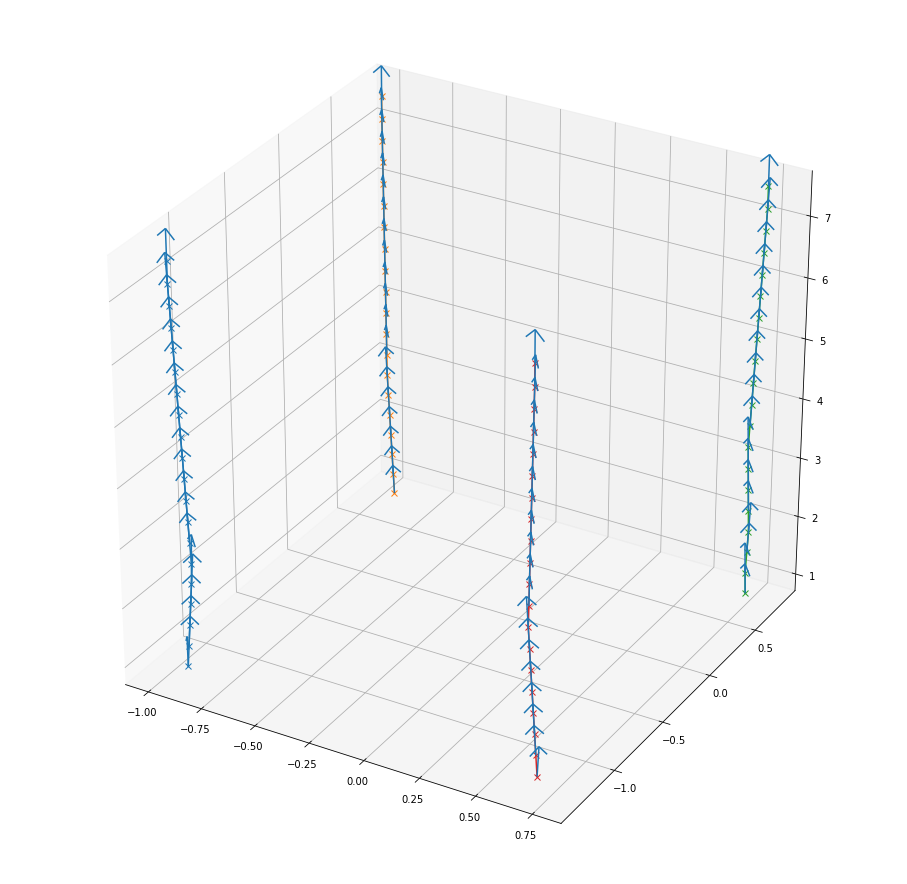

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111, projection = '3d')

for i in range(len(handles)):
    trajectory = (np.cumsum(param_v.detach().numpy()[:,i,:]*0.04,axis=0) + flat_mesh.vertices[handles[i]]).T
    grad = (param_v.detach().numpy()[:,i,:]).T
    ax.plot(trajectory[0], trajectory[1], trajectory[2], marker = 'x')
    ax.quiver(trajectory[0], trajectory[1], trajectory[2], grad[0], grad[1], grad[2], length=0.5, normalize=True) #set z component to 0 to better visualize other gradients. this seems useful

plt.show()